In [1]:
import os
import copy
import time
import asyncio
import warnings
import logging

from pathlib import Path

import numpy as np
from astropy.io import fits

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
from astropy.modeling import models, fitting


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]

#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

%matplotlib inline

In [2]:
import wget

In [3]:
from lsst.ts import salobj
from lsst.ts.standardscripts.auxtel.attcs import ATTCS
import asyncio

In [4]:
attcs = ATTCS()
cam = salobj.Remote(attcs.domain, "GenericCamera", 1)

In [5]:
await asyncio.gather(attcs.start_task, cam.start_task) 

RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 50 messages
RemoteEvent(ATAOS, 0, logMessage) falling behind; read 10 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 22 messages


[[None, None, None, None, None, None, None], None]

RemoteEvent(ATMCS, 0, target) falling behind; read 56 messages


## Declare target

In [6]:
# Declare target name
target_name='ksiPup'

In [ ]:
# Print Hexapod Current position (given by last successful command)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.aget(timeout=10)
print('Current Hexapod position from evt_positionUpdate: \n x= {}, \n y= {}, \n z= {}, \n U= {}, \n V= {}'
      .format(curr_hex_pos.positionX, curr_hex_pos.positionY, curr_hex_pos.positionZ, curr_hex_pos.positionU, curr_hex_pos.positionV))

In [ ]:
hex_X, hex_Y, hex_Z, hex_U, hex_V, hex_R = [-4.350, 0.100, 0.518, 0.350, 0.220, 0.000]

hex_X, hex_Y, hex_Z, hex_U, hex_V, hex_R = [-4.350, 0.100, 0.518-0.060, 0.350, 0.220, 0.000]

print('Command to Hexapod in-focus position')
await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, 
                                                   y=hex_Y,
                                                   z=hex_Z, 
                                                   u=hex_U, 
                                                   v=hex_V)

In [52]:
dz=1.5
focus_offset = 70.18853183/1e3/4.2
expTime=30.0
print(focus_offset)

0.016711555197619046


RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 36 messages


In [42]:
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=0.)

In [53]:
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=focus_offset)
try:
    curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)
except asyncio.TimeoutError:
    print("Timedout")

In [28]:
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="x", offset=-0.6881088203816793)
try:
    curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)
except asyncio.TimeoutError:
    print("Timedout")

In [33]:
await cam.cmd_startLiveView.set_start(expTime=0.5)

In [88]:
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="m1", offset=0.e3)

In [89]:
try:
    await cam.cmd_stopLiveView.start()
except salobj.AckError:
    print("ack error")

# Intrafocal hexapod setting - offsets -0.5mm from central focus value above

print('Move to intrafocal position')
# await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
#                                              z=hex_Z-dz, u=hex_U, v=hex_V)
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=-dz+focus_offset)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

print('Take intrafocal image')
cam.evt_endReadout.flush()

await cam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name+'_intra')

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=1)

print(intra_endron.imageName)

# Extrafocal hexapod setting
print('Move to extra-focal hexapod position')
# await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
#                                                      z=hex_Z+dz, u=hex_U, v=hex_V)
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=dz+focus_offset)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

# r.evt_endReadout.flush()
print('Take extra-focal image')
cam.evt_endReadout.flush()
await cam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name+'_extra')

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=1)

print(extra_endron.imageName)

try:
    await cam.cmd_startLiveView.set_start(expTime=0.5)
except salobj.AckError:
    print("ack error")

attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=focus_offset)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

Move to intrafocal position
Take intrafocal image
1579843128-ksiPup_intra-0-1
Move to extra-focal hexapod position
Take extra-focal image
1579843172-ksiPup_extra-0-1
1579843128-ksiPup_intra-0-1.fits
1579843172-ksiPup_extra-0-1.fits


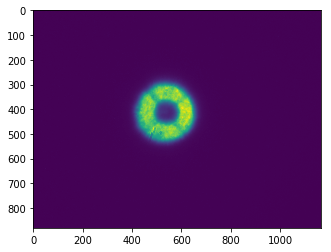

In [90]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

In [91]:
# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

1 2
Creating stamps of centroid [y,x] = [412,535] with a side length of 150 pixels


RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 14 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 51 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 52 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 13 messages


In [92]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

In [93]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)



Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


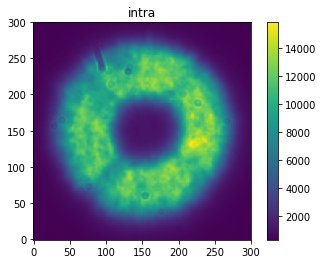

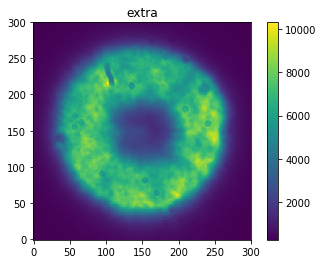

Extra-focal filename: 1579843172-ksiPup_extra-0-1.fits
Intra-focal filename: 1579843128-ksiPup_intra-0-1.fits


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 16 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 16 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 17 messages


In [94]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

[ 27.15068591 -66.84300224  25.56913197 -10.23256595  28.29456617
 -66.56895846   2.49128496  19.54191573  -4.24850282   2.04877895
 -50.84116218  34.82258368   6.52298481  -3.43085104  -4.40474989
  -5.12512629 -12.20524313  -1.94151373 -13.54982264]


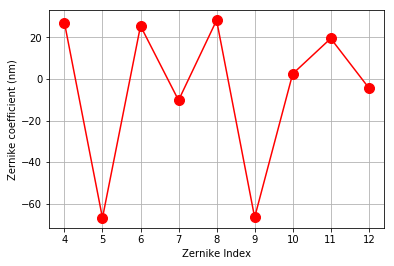

RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 74 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 72 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 75 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 75 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 75 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 75 messages
RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 15 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 75 messages
RemoteEvent(ATD

In [95]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

[-32.01189488 -36.0230946  -22.5909387  -27.54540303  32.59538006
 -56.28139713 -81.14560764 -23.87978693  -7.71627873  22.4401865
 -40.96365046 -14.27048068   6.60440799 -13.27157965  -2.3392849
   7.82236526 -25.39834068 -10.85145508  -7.17924473]


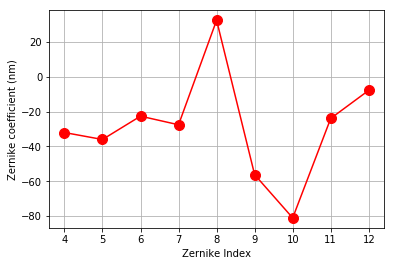

RemoteEvent(ATAOS, 0, detailedState) falling behind; read 16 messages
RemoteEvent(ATMCS, 0, heartbeat) falling behind; read 77 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 77 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 76 messages
RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 58 messages
RemoteEvent(ATAOS, 0, logMessage) falling behind; read 100 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 76 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 74 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 77 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 77 messages
RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read

In [40]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

[-70.18853183 -17.7630992   75.85567001 -35.20749007  29.88020699
 -50.34099631   1.87793559   4.24043121 -14.31946704  -0.4435168
 -25.24026771 -23.08313852   6.42392329   1.13035942  -2.28571941
   1.12704366  11.19090476 -19.02220774 -17.71562281]


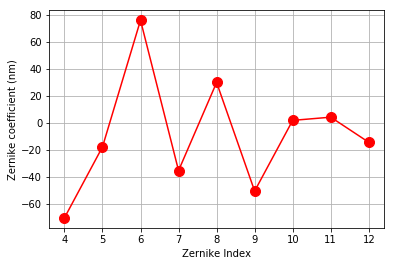

RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 72 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 72 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 71 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 70 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 72 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 71 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 72 messages
RemoteEvent(ATAOS, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 72 messages
RemoteEvent(ATDomeTrajectory, 0, heartb

In [51]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

[  1.40472352  37.92627228 -17.61408708 -41.86667072  19.25169384
 -75.84285071  28.77031652  23.87553913  -2.58867778   5.23731894
 -27.84387606   4.92290388   9.31726088  -1.09829057  -2.3357577
   1.23268722   3.40138514   6.23142995 -24.97364949]


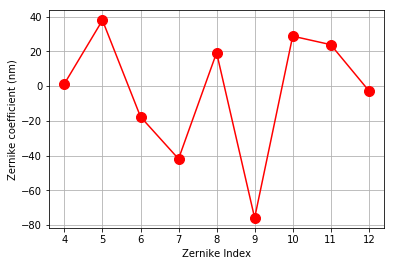

RemoteEvent(ATAOS, 0, detailedState) falling behind; read 17 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 74 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 73 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 75 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 15 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 76 messages
RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 78 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 75 messages
RemoteEvent(ATDomeTrajectory, 0

In [60]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

In [27]:
-90.14225547/131

-0.6881088203816793